# Classification with Iris Dataset 

## Import libraries

In [1]:
import pandas as pd
import numpy as np

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, \
                             GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
warnings.filterwarnings('ignore')

## Load data
I downloaded the data from the UCI machine learning repository. Thankfully there are no missing values in this dataset, which is always handy.

In [3]:
data = pd.read_csv(r'C:\Users\kaiaj_000\Documents\iris.csv')

## Feature exploration
There are only four features in this dataset, however, they are still worth exploring to see if I can create any new features from them. Firstly I will convert the 'variety' column into seperate columns for each label so that I can plot their correllations with the features of the data.

In [4]:
for label in data['variety'].unique():
    
    data[label] = 0
    data.loc[data['variety'] == label, label] = 1

Now I use the heatmap function of the Seaborn library to plot the correllations between the features and the labels. 

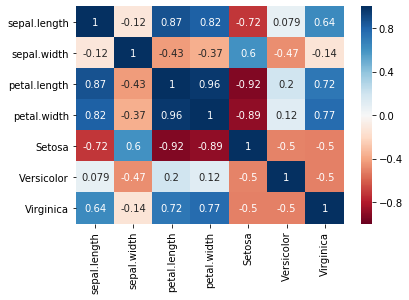

In [5]:
sns.heatmap(data.corr(), -1, 1, plt.cm.RdBu, annot=True)
plt.show()

As can be seen from the plot the features are fairly correllated which would make me think of either deleting some of them, or performing dimensionality reduction, however since there are only four features, I choose to leave the features how they are. 

Also from the plot, I notice that 'sepal length' and 'sepal width' are not very correlated, and yet they are both correlated with some of the variety labels. This leads me to create a new feature by multiplying 'sepal length' and 'sepal width'. The result will be a new feature which is not highly correlated with the other features, and yet is correlated with some of the variety labels making it easier to classify each type of plant. This is very much a win-win situation.

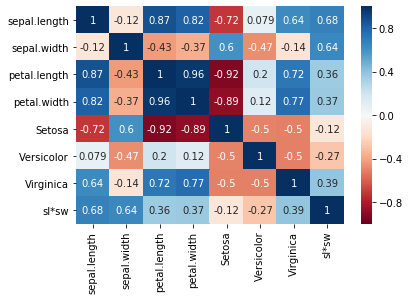

In [6]:
data['sl*sw'] = data['sepal.length'] * data['sepal.width']

# A look at my new feature
sns.heatmap(data.corr(), -1, 1, plt.cm.RdBu, annot=True)
plt.show()

## Data preprocessing
In this section, I will be doing two things: firstly converting the variety column into a one-hot encoded target variable, and secondly spltting the data into training and testing data. I decide to one-hot encode the variety column so that each label is represented as either being present or not. This works better than simply assigning each label a number from one to three, as this would suggest that they are ordinal labels, i.e. that one type of plant is simply one of the other types of plant but scaled up or down by a factor of two or three. This is obviously nonsense, which is why I choose not to turn the variety variable into an ordinal variable.

In [7]:
# drop the 'Setosa', 'Versicolor', and 'Virginica' variables, as they are no longer needed.
data = data.drop(['Setosa', 'Versicolor', 'Virginica'], 1)

labels = np.zeros((150, 3))

n = 0
for label in data['variety'].unique():

    labels[data['variety'] == label, n] = 1

    n += 1

## Modelling
Now on to the interesting part. I will start by simply testing one model on the data, with that model being the linear svc. I choose this aproach as the linear svc is an inflexible model, meaning that it tends to fit to data in a linear rather than a polynomial fashion. This is ideal for this dataset since I believe there will be a mostly linear realtionship between the features and the target, because there are not many features, and the features have a good correlation with at least one of the classes. Starting with one model will save me a lot of time which is essential when it comes to real world machine learning problems. This time could then be spent on more produtive tasks such as collecting more data which would be of great help in this problem since there really is not enough data here to build a truly accurate representation of the relationship between the features and the target.

To test out my model, I define a score function which prints the training accuracy and the validaton accuracy of the model. I will call the funtion five times to adjust for the inevitable variance in scores due to the lack of data. In the score function I will split the data into a train and test set. I do this inside the function so as to take advantage of the random_state argument of the train_test_split class, hopefully splitting the data up differently on each iteration.

In [8]:
# prefer dual=False when n samples > n features
lsvc = LinearSVC(dual=False)

def score(model):
    print('-' * 125)

    print(model.__class__.__name__, '\n')
    
    train, test = train_test_split(data, test_size=.2, stratify=data['variety'])
    
    train_x = train.drop('variety', 1)
    train_y = train['variety']
    
    model.fit(train_x, train_y)

    print("train accuracy: ", model.score(train_x, train_y), '\n')

    score = cross_val_score(model, train_x, train_y, scoring='accuracy', cv=5)

    print("validation accuracy: ", score.mean())

    print('-' * 125)
    
for i in range(5):
    
    score(lsvc)

-----------------------------------------------------------------------------------------------------------------------------
LinearSVC 

train accuracy:  0.95 

validation accuracy:  0.9416666666666667
-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
LinearSVC 

train accuracy:  0.975 

validation accuracy:  0.9333333333333332
-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
LinearSVC 

train accuracy:  0.9583333333333334 

validation accuracy:  0.9416666666666667
----------------------------------------------------------------------------------------------------------------------------

Not too bad! The model has achieved a high validation accuracy, and the difference between the training accuracy and the validation accuracy is small. This suggests that the model has fit to the data well, but has not overfitted the data.  

Some scikit-learn models have an attribute which lets the user view the importance of the features. Fortunatley, the linear svc is one of them. It has an attribute called "coef_" which returns an array of the weghts assigned to each feature with respect to each class. Using this, I will determine which features are contributing towards the overall accuracy, and which features are not.

In [9]:
# outputs an array with shape [n features, n classes]
lsvc.coef_

array([[ 0.12159544,  0.24245324, -0.84653631, -0.42683527,  0.06858418],
       [ 0.12359633,  0.01028522,  0.54763078, -0.86140214, -0.16053594],
       [-1.0535324 , -1.74981557,  1.33159887,  1.6261997 ,  0.17489432]])

I can see that most features, except for the 'sl*sw' feature, have a strong correlation with at least one of the classes. Despite the 'sl*sw' feature not adding much to the model's performance, I deicde that it is enough to justify keeping it.

Finally, I will use scikit-learn's GridSearchCV class to determine whether adjusting the hyperparameters is worthwhile. I will again define a score function that will function the same as the previous score function, only differing in the method of validation, which will be executed by the GridSeacrhCV class instead of the cross_val_score class.  

In [10]:
# Create a parameter grid for the GridSearchCV class to search
param_grid = {'penalty': ['l1', 'l2'], 'tol': [1e-3, 1e-4, 1e-5], 'C': [.01, .1, 1], 'max_iter': [10, 100, 1000]}

def GridSearch(model):
    print('-' * 125)

    print(model.__class__.__name__, '\n')
    
    train, test = train_test_split(data, test_size=.2, stratify=data['variety'])
    
    train_x = train.drop('variety', 1)
    train_y = train['variety']
    
    grid_search = GridSearchCV(lsvc, param_grid, 'accuracy', cv=5)
    grid_search.fit(train_x, train_y)

    print("train accuracy: ", grid_search.score(train_x, train_y), '\n')

    print("validation accuracy: ", grid_search.best_score_)

    print('-' * 125)
    
for i in range(5):
    
    GridSearch(lsvc)

-----------------------------------------------------------------------------------------------------------------------------
LinearSVC 

train accuracy:  0.9583333333333334 

validation accuracy:  0.95
-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
LinearSVC 

train accuracy:  0.9666666666666667 

validation accuracy:  0.9583333333333334
-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
LinearSVC 

train accuracy:  0.9666666666666667 

validation accuracy:  0.95
-----------------------------------------------------------------------------------------------------------------------------

Interestingly, the model has performed very similarly to its inital version. This suggests that the hyperparamaters were already sufficiently tuned. I decide then to keep the inital hyperparameters.

To finish off this notebook, its time for the moment of truth: testing. I define a test function.

In [11]:
def test(model):
    print('-' * 125)

    print(model.__class__.__name__, '\n')
    
    train, test = train_test_split(data, test_size=.2, stratify=data['variety'])
    
    train_x = train.drop('variety', 1)
    train_y = train['variety']
    
    test_x = test.drop('variety', 1)
    test_y = test['variety']
    
    model.fit(train_x, train_y)

    print("test accuracy: ", model.score(test_x, test_y), '\n')

    print('-' * 125)
    
for i in range(5):
    
    test(lsvc)

-----------------------------------------------------------------------------------------------------------------------------
LinearSVC 

test accuracy:  1.0 

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
LinearSVC 

test accuracy:  0.9666666666666667 

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
LinearSVC 

test accuracy:  0.9666666666666667 

-----------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------

An average test score of roughly 93% is good considering the lack of samples in the data. Therefore to conclude, I am happy with the result :)